In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
import re
from typing import Optional
from nerfstudio.cameras.rays import RaySamples, Frustums
from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils import colormaps, misc

from reni.configs.reni_config import RENIField
from reni.configs.sh_sg_envmap_configs import SHField, SGField
from reni.pipelines.reni_pipeline import RENIPipeline
from reni.field_components.field_heads import RENIFieldHeadNames
from reni.data.datamanagers.reni_datamanager import RENIDataManager
from reni.utils.utils import find_nerfstudio_project_root, rot_z, rot_y
from reni.utils.colourspace import linear_to_sRGB

In [ ]:
# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

def load_model(load_dir: Path, load_step: Optional[int] = None):
    ckpt_dir = load_dir / 'nerfstudio_models'
    def clean_and_load_yaml(yaml_content):
        # Remove !!python related tags
        cleaned_content = re.sub(r'!!python[^\s]*', '', yaml_content)
        
        # Load the cleaned content
        return yaml.safe_load(cleaned_content)

    if load_step is None:
        load_step = sorted(int(x[x.find("-") + 1 : x.find(".")]) for x in os.listdir(ckpt_dir))[-1]
    
    ckpt = torch.load(ckpt_dir / f'step-{load_step:09d}.ckpt', map_location=device)
    reni_model_dict = {}
    for key in ckpt['pipeline'].keys():
        if key.startswith('_model.'):
            reni_model_dict[key[7:]] = ckpt['pipeline'][key]
    
    config_path = load_dir / 'config.yml'
    with open(config_path, 'r') as f:
        content = f.read()
        config = clean_and_load_yaml(content)
    
    if 'latent_dim' in config['pipeline']['model']['field'].keys():
        
        model_config = RENIField.config
        model_config.pipeline.datamanager.dataparser.convert_to_ldr = config['pipeline']['datamanager']['dataparser']['convert_to_ldr']
        model_config.pipeline.datamanager.dataparser.convert_to_log_domain = config['pipeline']['datamanager']['dataparser']['convert_to_log_domain']
        if config['pipeline']['datamanager']['dataparser']['eval_mask_path'] is not None:
            eval_mask_path = Path(os.path.join(*config['pipeline']['datamanager']['dataparser']['eval_mask_path']))
            model_config.pipeline.datamanager.dataparser.eval_mask_path = eval_mask_path
        else:
            model_config.pipeline.datamanager.dataparser.eval_mask_path = None
        if config['pipeline']['datamanager']['dataparser']['min_max_normalize'].__class__ == list:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = tuple(config['pipeline']['datamanager']['dataparser']['min_max_normalize'])
        else:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = config['pipeline']['datamanager']['dataparser']['min_max_normalize']
        model_config.pipeline.datamanager.dataparser.augment_with_mirror = config['pipeline']['datamanager']['dataparser']['augment_with_mirror']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
        model_config.pipeline.model.field.conditioning = config['pipeline']['model']['field']['conditioning']
        model_config.pipeline.model.field.invariant_function = config['pipeline']['model']['field']['invariant_function']
        model_config.pipeline.model.field.equivariance = config['pipeline']['model']['field']['equivariance']
        model_config.pipeline.model.field.axis_of_invariance = config['pipeline']['model']['field']['axis_of_invariance']
        model_config.pipeline.model.field.positional_encoding = config['pipeline']['model']['field']['positional_encoding']
        model_config.pipeline.model.field.encoded_input = config['pipeline']['model']['field']['encoded_input']
        model_config.pipeline.model.field.latent_dim = config['pipeline']['model']['field']['latent_dim']
        model_config.pipeline.model.field.hidden_features = config['pipeline']['model']['field']['hidden_features']
        model_config.pipeline.model.field.hidden_layers = config['pipeline']['model']['field']['hidden_layers']
        model_config.pipeline.model.field.mapping_layers = config['pipeline']['model']['field']['mapping_layers']
        model_config.pipeline.model.field.mapping_features = config['pipeline']['model']['field']['mapping_features']
        model_config.pipeline.model.field.num_attention_heads = config['pipeline']['model']['field']['num_attention_heads']
        model_config.pipeline.model.field.num_attention_layers = config['pipeline']['model']['field']['num_attention_layers']
        model_config.pipeline.model.field.output_activation = config['pipeline']['model']['field']['output_activation']
        model_config.pipeline.model.field.last_layer_linear = config['pipeline']['model']['field']['last_layer_linear']
        model_config.pipeline.model.field.trainable_scale = config['pipeline']['model']['field']['trainable_scale']
        model_config.pipeline.model.field.old_implementation = config['pipeline']['model']['field']['old_implementation']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
    elif 'spherical_harmonic_order' in config['pipeline']['model']['field'].keys():
        model_config = SHField.config
        model_config.pipeline.model.field.spherical_harmonic_order = config['pipeline']['model']['field']['spherical_harmonic_order']
    elif 'row_col_gaussian_dims' in config['pipeline']['model']['field'].keys():
        model_config = SGField.config
        model_config.pipeline.model.field.row_col_gaussian_dims = config['pipeline']['model']['field']['row_col_gaussian_dims']

    pipeline: RENIPipeline = model_config.pipeline.setup(
      device=device,
      test_mode=test_mode,
      world_size=world_size,
      local_rank=local_rank,
      grad_scaler=None,
    )

    datamanager = pipeline.datamanager

    model = pipeline.model

    model.to(device)
    model.load_state_dict(reni_model_dict)
    model.eval()

    return pipeline, datamanager, model

def generate_images_from_models(image_indices, model_paths):
    all_model_outputs = {}
    
    for model_path in model_paths:
        model_name = model_path.split("/")[-1]
        pipeline, datamanager, model = load_model(Path(model_path))
        
        model_outputs = {}
        
        for idx in image_indices:
            # Your code to produce an image would go here.
            model.eval()
            _, ray_bundle, batch = datamanager.next_eval_image(idx)

            image_idx, camera_ray_bundle, batch = pipeline.datamanager.next_eval_image(0)
            outputs = pipeline.model.get_outputs_for_camera_ray_bundle(camera_ray_bundle, batch)
            metrics_dict, images_dict = pipeline.model.get_image_metrics_and_images(outputs, batch)

            gt_environment_map = datamanager.eval_dataset.environment_maps[idx]

    
    return all_model_outputs

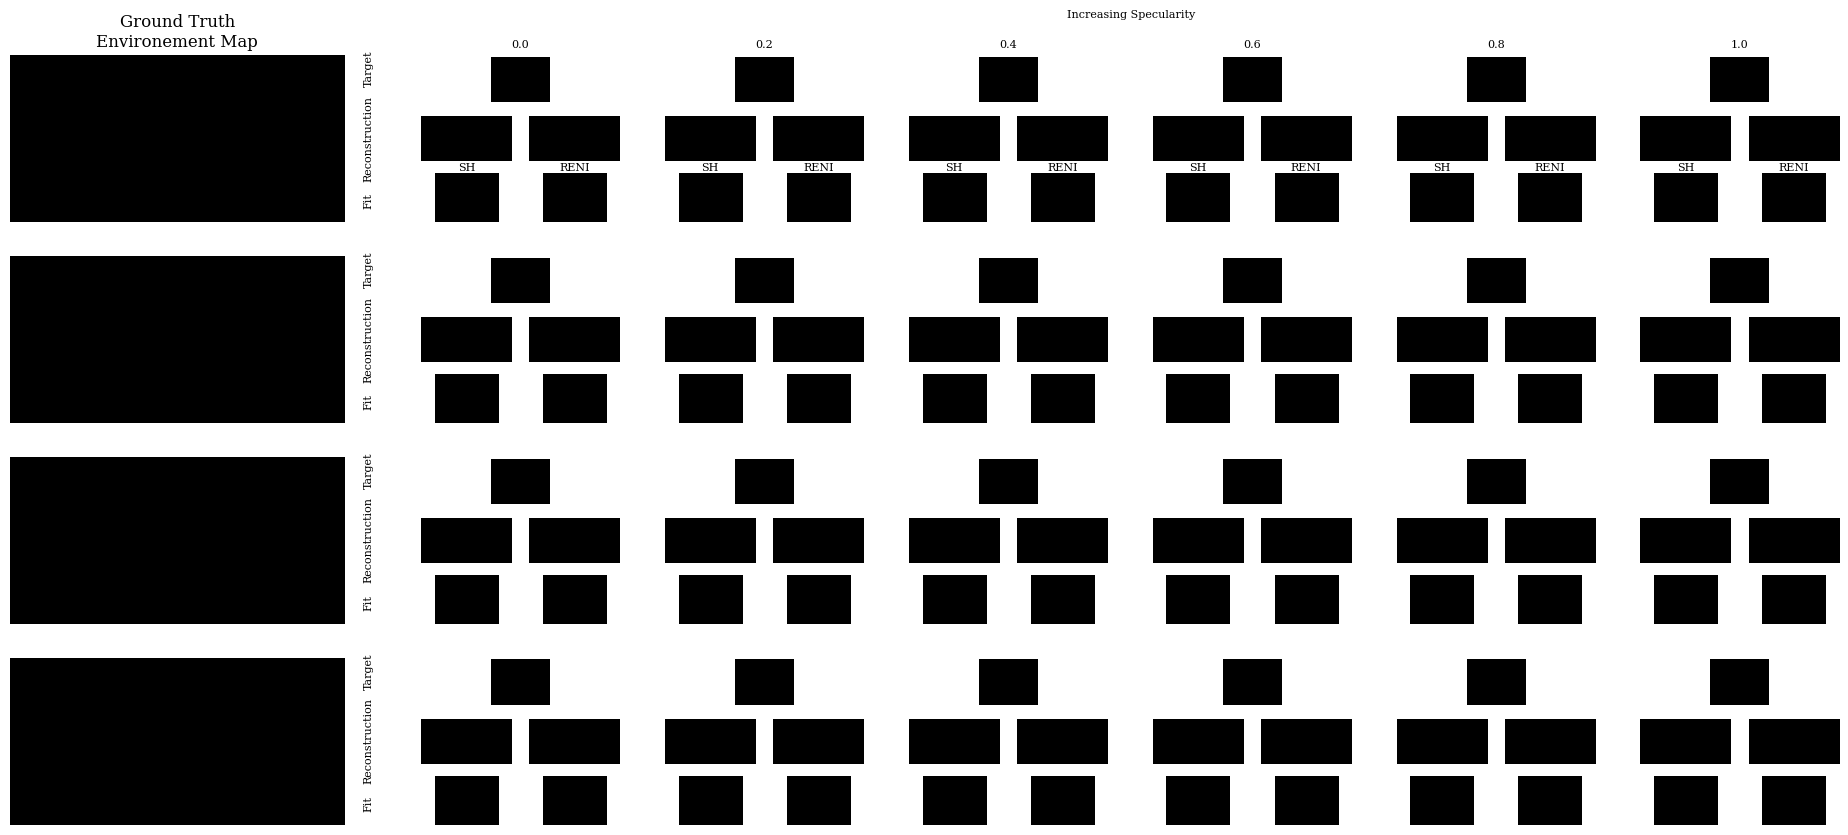

In [23]:
import matplotlib.pyplot as plt
import torch
from matplotlib import gridspec
import matplotlib.patches as mpatches

plt.rc('font', family='serif')

# Create blank tensors
equirectangular_tensor = torch.zeros((128, 256, 3))  # Equirectangular images
teapot_tensor = torch.zeros((100, 128, 3))          # Teapot images

fig = plt.figure(figsize=(24, 10))  # Adjusted figure size for demonstration

# Define the outer grid (1 row, 2 cols)
outer_grid = gridspec.GridSpec(4, 7, width_ratios=[2, 1, 1, 1, 1, 1, 1])
# add axis title to top of right column of outer grid
fig.text(
    0.605, 0.92, 
    'Increasing Specularity',
    rotation=0, 
    ha='center', va='center',
    fontsize=8
)

for i in range(4):
    # Place the equirectangular image in the left column of the outer grid
    ax_equirect = fig.add_subplot(outer_grid[i, 0])
    ax_equirect.imshow(equirectangular_tensor.numpy())
    ax_equirect.axis('off')
    if i == 0:
        ax_equirect.set_title('Ground Truth\nEnvironement Map')

    pos = ax_equirect.get_position()
    fig.text(
        pos.x1 + 0.01, pos.y0 + pos.height/1.09, 
        'Target',
        rotation=90, 
        ha='center', va='center',
        fontsize=8
    )
    fig.text(
        pos.x1 + 0.01, pos.y0 + pos.height/2, 
        'Reconstruction',
        rotation=90, 
        ha='center', va='center',
        fontsize=8
    )
    fig.text(
        pos.x1 + 0.01, pos.y0 + pos.height/8, 
        'Fit',
        rotation=90, 
        ha='center', va='center',
        fontsize=8
    )


    for idx, specular in enumerate([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):
        # Define the right column grid (3 rows, 1 col)
        column_grid = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer_grid[i, idx + 1])

        # Top row of the right column split into 3 cols for teapots
        top_row_grid = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=column_grid[0])
            
        ax = fig.add_subplot(top_row_grid[1])
        ax.imshow(teapot_tensor.numpy())
        ax.axis('off')
        if i == 0:
            ax.set_title(f'{specular:.1f}', fontdict={'fontsize': 8})
        # ax.set_title(f'Teapot GT for Specular {specular:.1f}')

        # Middle row of the right column split into 2 cols for equirectangular images
        middle_row_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=column_grid[1])
        for j in range(2):
            ax = fig.add_subplot(middle_row_grid[j])
            ax.imshow(equirectangular_tensor.numpy())
            ax.axis('off')
            # ax.set_title(f'Pred Equirectangular {"SH" if i == 0 else "RENI"}')

        # Bottom row of the right column split into 8 cols for teapots
        # But merge cols for teapot under each equirectangular image
        bottom_row_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=column_grid[2])

        # Place a single teapot image under the first equirectangular image (spanning cols 1-2)
        ax_teapot1 = fig.add_subplot(bottom_row_grid[0])
        ax_teapot1.imshow(teapot_tensor.numpy())
        ax_teapot1.axis('off')
        if i == 0:
            ax_teapot1.set_title('SH', fontsize=8, pad=-1)

        # Place a single teapot image under the second equirectangular image (spanning cols 5-6)
        ax_teapot2 = fig.add_subplot(bottom_row_grid[1])
        ax_teapot2.imshow(teapot_tensor.numpy())
        ax_teapot2.axis('off')
        if i == 0:
            ax_teapot2.set_title('RENI', fontsize=8, pad=-1)

# plt.tight_layout()
plt.show()

